In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [ ]:
# Load the dataset (adjust path as needed)
df = pd.read_csv('/content/AAPL.csv', date_parser=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use only the 'Close' price for prediction
data = df[['Close']]  # You can use any column like 'Open', 'Volume', etc.

# Normalize the data using MinMaxScaler (LSTM is sensitive to scale)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and test datasets (80-20 split)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


<ipython-input-2-9ee48c4f59db>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/AAPL.csv', date_parser=True)


In [ ]:
# Function to create sequences of data for LSTM
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Prepare the training and testing datasets
time_step = 60  # 60 days of data to predict the next day's price

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape X_train and X_test to be 3D (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Build the LSTM model
model = Sequential()

# Adding LSTM layer with 50 units and input shape
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Adding a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 1.0188e-04 - val_loss: 0.0017
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 9.8139e-06 - val_loss: 0.0012
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 9.5772e-06 - val_loss: 7.5357e-04
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 1.1311e-05 - val_loss: 4.5972e-04
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 9.5891e-06 - val_loss: 9.0635e-04
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 9.7495e-06 - val_loss: 0.0020
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 9.6747e-06 - val_loss: 0.0028
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 1.0164e-05 - val_loss: 0.0021
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 7.8129e-06 - val_loss: 0.0030
Epoch 10/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 8.1874e-06 - val_loss: 0.0016


In [ ]:
# Predict the stock price on the test data
predicted_stock_price = model.predict(X_test)

# Inverse transform the predictions and actual values to get original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE or accuracy
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price))
print(f'Root Mean Squared Error (RMSE): {rmse}')


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error (RMSE): 7.292695696826083


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_actual, predicted_stock_price)
print(f'R² Score (Accuracy): {r2 * 100:.2f}%')


R² Score (Accuracy): 97.44%


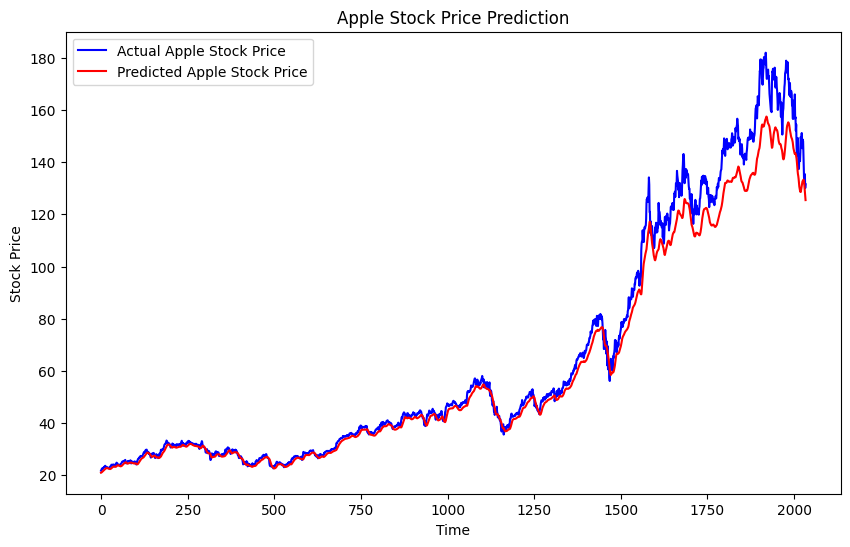

In [ ]:
# Visualize the results
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
